# Modelling COVID-19 data
---

## Import libraries
---

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd
import statsmodels.api as sm
# We can override the default matplotlib styles with those of Seaborn
import seaborn as sns
sns.set()

## Load the data
---

This data has been sourced from the Our World in Data <a href="https://ourworldindata.org/coronavirus-source-data">website</a> which in turn was sourced from the  World Health Organization (WHO) <a href="https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/">Situation Reports</a>. The WHO Situation Reports are published daily [reporting data as of 10am (CET; Geneva time)]. The main section of the Situations Reports are long tables of the latest number of confirmed cases and confirmed deaths by country.

In published WHO Situation Reports were several inconsistencies in the number of total confirmed cases, and new confirmed cases that we noticed between the WHO Situation Reports and the <a href="https://experience.arcgis.com/experience/685d0ace521648f8a5beeeee1b9125cd">WHO Dashboard</a>, which also presents these statistics. These discrepancies are detailed <a href="https://ourworldindata.org/coronavirus-source-data">here</a>.

Our World in Data have informed the WHO about these inconsistencies and are working closely in an effort to resolve these issues. We continue to be in close contact with the WHO data team to ensure the latest statistics are presented accurately.

Note that none of these inconsistencies are major. It is not the case that figures published by the WHO have large errors. The inconsistencies are small and do not affect the **overall perspective on the development of COVID-19** in any major way.

In [131]:
# Load the data from a .csv in the same folder
data = pd.read_csv('full_data_16_march.csv')

# Create new data frame where the location is only the world
world = data[data['location'] == 'World']

# Reset the index
world = world.reset_index(drop=True)

Any **NaN** values in the table represent blank values in the data. From here we can filter the table to include **only the World** data.

## Visualise the data
---

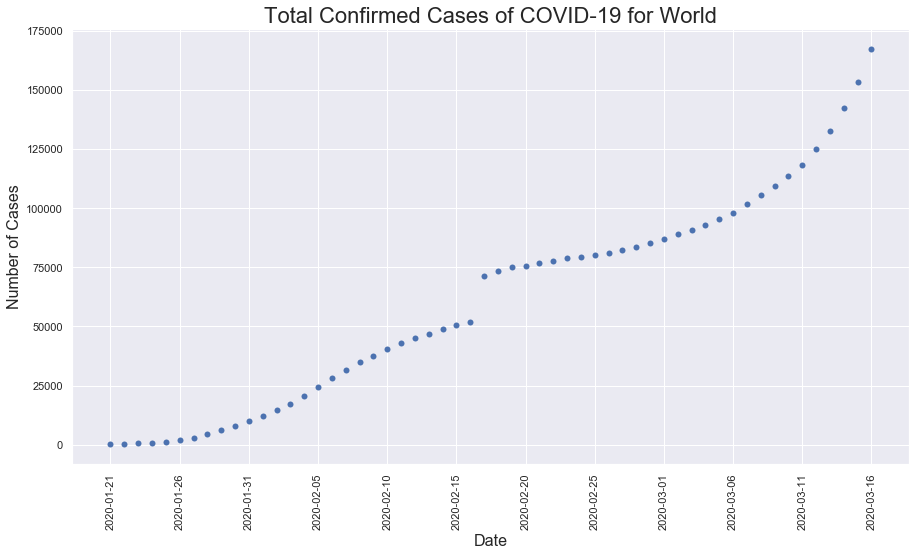

In [132]:
# Customise the size of the figure
plt.subplots(nrows=1, ncols=1,figsize=(15,8))

# Define variables
x1 = world['date']
y1 = world['total_cases']

# Plot the data
plt.plot(x1, y1,
         marker='.', ms=12, markeredgecolor='none',
         linestyle='none', label='Total Cases')

# Keep every 5th row for x-axis ticks
temp = world[world.index % 5 == 0]

plt.xticks(list(temp['date']), rotation='vertical')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Cases', fontsize=16)
plt.title('Total Confirmed Cases of COVID-19 for World', fontsize=22)
plt.show()

The data shows an initial growth that then sarted to level out. This is primarily caused by **China** now that the country is starting to recover. Most of the cases were there initially, taking **larger significance** over the world data. Working from 2020-02-20 onward, we can see that the world data is showing signs of an **exponential growth** after the results of China recovering.

We can filter the data set further to only include `'dates' >= '2020-02-20'`:

In [133]:
# Remove data before 2020-02-20
n = world[world['date'] == '2020-02-20'].index.values
world = world[world.index >= n[0]]

# Reset the index
world = world.reset_index(drop=True)

display(world)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-20,World,542.0,115.0,75748.0,2129.0
1,2020-02-21,World,1021.0,118.0,76769.0,2247.0
2,2020-02-22,World,1023.0,112.0,77794.0,2359.0
3,2020-02-23,World,1017.0,102.0,78811.0,2463.0
4,2020-02-24,World,517.0,155.0,79331.0,2618.0
5,2020-02-25,World,896.0,82.0,80239.0,2700.0
6,2020-02-26,World,864.0,62.0,81109.0,2762.0
7,2020-02-27,World,1175.0,42.0,82294.0,2804.0
8,2020-02-28,World,1353.0,54.0,83652.0,2858.0
9,2020-02-29,World,1748.0,66.0,85403.0,2924.0


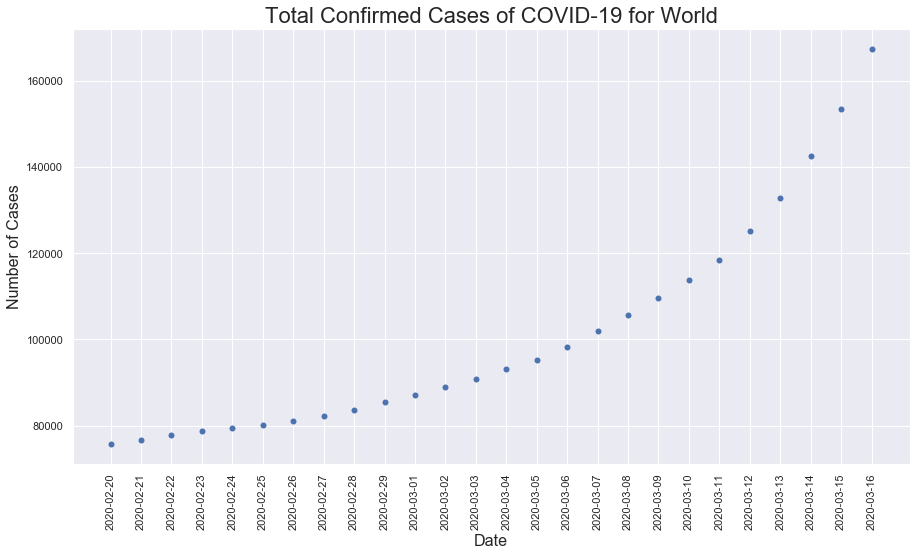

In [134]:
# Customise the size of the figure
plt.subplots(nrows=1, ncols=1,figsize=(15,8))

# Define variables
x2 = world['date']
y2 = world['total_cases']

# Plot the data
plt.plot(x2, y2,
         marker='.', ms=12, markeredgecolor='none',
         linestyle='none', label='Total Cases')

plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Cases', fontsize=16)
plt.title('Total Confirmed Cases of COVID-19 for World', fontsize=22)
plt.show()

## Least squares polynomial regression
---
### General model
---

The most common method to express the relationship between variables in a data set as an equation is with a $k^\text{th}$ order polynomial of the form:

$$\Large p(x) = \varepsilon + a_0 + a_1x + \cdots + a_kx^k$$

where $\mathbf{a} = (a_k, a_{k-1}, \ldots, a_0)$ are the **polynomial coefficients**, $k$ is the **degree** of the polynomial and $\varepsilon$ is the **error**. This is referred to as the **general polynomial regression model** and the error serves as a reminder that it's an estimation.

### Polynomial order
---

For a set of $N$ data points, you can always find a polynomial of degree $k = N - 1$ which passes through all of them. It is best practice to keep the degree as **low as possible** to accurately represent the data set as higher degrees can cause **polnomial wiggle**. For this example, I am going to model the data using a $4^\text{th}$ degree polynomial and I will illustrate the reason why at the end. To clatify, this will have the form:

$$\Large p(x) = a_0 + a_1x + a_2x^2 + a_3x^3 + a_4x^4\tag{1}$$

### Estimating the polynomial coefficients
---

The general polynomial regression model can be developed using the method of **least squares** which aims to minimise the variance between estimated values and the expected values from the data set. First, using a $4^\text{th}$ degree polynomial, force the polynomial to match the data at each of the x-coordinates:

$$\Large\begin{align*}
p(0) &= a_0 + a_1\cdot0 + a_2\cdot0^2 + a_3\cdot0^3 + a_4\cdot0^4 = 75748\\
p(1) &= a_0 + a_1\cdot1 + a_2\cdot1^2 + a_3\cdot1^3 + a_4\cdot1^4 = 76769\\
p(2) &= a_0 + a_1\cdot2 + a_2\cdot2^2 + a_3\cdot2^3 + a_4\cdot2^4 = 77794\\
&\vdots\\
p(25) &=a_0 + a_1\cdot25 + a_2\cdot25^2 + a_3\cdot25^3 + a_4\cdot25^4 = 167502
\end{align*}$$

This gives a system of **26 linear equations** with **4 unknowns** which can be written as:

$$\Large\mathrm{A}\mathbf{a} = \mathbf{y}\tag{2}$$

where $\mathrm{A}$ is a **square matrix** of numbers, $\mathbf{y}$ is a column vector of numbers, and $\mathbf{a}$ is a column vector of unknowns. 

### Overdetermined equations
---

In this example, the linear system ends up as:

$$\Large
\begin{bmatrix}
    1 & 0 & 0^2 & 0^3 & 0^4 \\
    1 & 1 & 1^2 & 1^3 & 1^4 \\
    1 & 2 & 2^2 & 2^3 & 2^4 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & 25 & 25^2 & 25^3 & 25^4 \\
\end{bmatrix}
\begin{bmatrix}
    a_0 \\
    a_1 \\
    a_2 \\
    a_3 \\
    a_4 \\
\end{bmatrix}
=
\begin{bmatrix}
    75748 \\
    76769 \\
    77794 \\
    \vdots \\
    167502 \\
\end{bmatrix}$$

Here, the matrix $\mathrm{A}$ **is not square**. We have an **overdetermined** linear system because the number of equations is greater than the number of unknowns (i.e. for an $n\times m$ matrix, $n>m$). For this we multiply both sides by $\mathrm{A}^T$, which is the transpons of $\mathrm{A}$, giving the square linear system:

$$\Large\begin{align*}
\mathrm{A}^T\mathrm{A}\mathbf{a} = \mathrm{A}^T\mathbf{y}
\end{align*}$$

Rewriting this in the form of equation $(2)$ gives:

$$\Large\mathrm{M}\mathbf{a} = \mathbf{b}$$

where $\mathrm{M} = \mathrm{A}^T\mathrm{A}$ and $\mathbf{b} = \mathrm{A}^T\mathbf{y}$. Assuming that $\mathrm{M}$ in **invertible**, the least squares solution is given by:

$$\Large\mathbf{a} = \mathrm{M}^{-1}\mathbf{b}$$

$\mathrm{M}$ is invertible if its **determinant** is **non-zero**, denoted as:

$$\Large\mathrm{det}\left(\mathrm{M}\right) \neq 0$$

Using Numpy, we can calculate the determinant to verify that the square matrix is invertible.

In [135]:
# Frist, we create a 26 x 5 matrix with 0 for every element
rows = len(world.index) #  26: 0 to 25
columns = 5 # k-1: 0 to 4
A = np.zeros((rows, columns))

# Next, we overwrite each row [0, 0, 0, 0, 0] with the following
for i in range(rows):
    A[i,:] = [1, i, i**2, i**3, i**4]

# Finally, we calculate the dot product of the Transpose(A) and A
# and take the determinant
T_A = A.transpose()
M = np.dot(T_A, A)
detM = np.linalg.det(M)

if detM == 0:
    print('det(M) = 0. The matrix is NOT invertible.')
else:
    print('det(M) != 0. The matrix is invertible.')

det(M) != 0. The matrix is invertible.


Therefore, the polynomial coefficients are:

In [136]:
# First, we calculate the dot product of the Transpose(A) and y
y = np.array(list(y2))
b = np.dot(T_A, y)

# Solve the equation
a = np.linalg.inv(M).dot(b)
coeff = pd.DataFrame({'coefficients': ['a_0', 'a_1', 'a_2', 'a_3', 'a_4'],
                      'value': a})
display(coeff)

,coefficients,value
0,a_0,76683.873710
1,a_1,-216.045101
2,a_2,253.243400
3,a_3,-17.927407
4,a_4,0.555456


Numpy has a built in function to perform these same calculations. Let's use it and compare the results.

In [137]:
# Overwrite variable a with the Numpy least squares function
a = np.linalg.lstsq(A, y, rcond=None)[0]

# Overwrite the data frame coeff using new value a
coeff = pd.DataFrame({'coefficients': ['a_0', 'a_1', 'a_2', 'a_3', 'a_4'],
                      'value': a})
display(coeff)

,coefficients,value
0,a_0,76683.873711
1,a_1,-216.045101
2,a_2,253.243400
3,a_3,-17.927407
4,a_4,0.555456


### Building the model
---
Now that we have our **estimated**, $4^\text{th}$ degree polynomial equation model:

$$\Large p(x) = 76683.87 - 216.05x + 253.24x^2 - 17.93x^3 + 0.56x^4$$

we can plot this over the data. Here I will also plot lower degree  least squares polynomial regressions to compare accuracy.

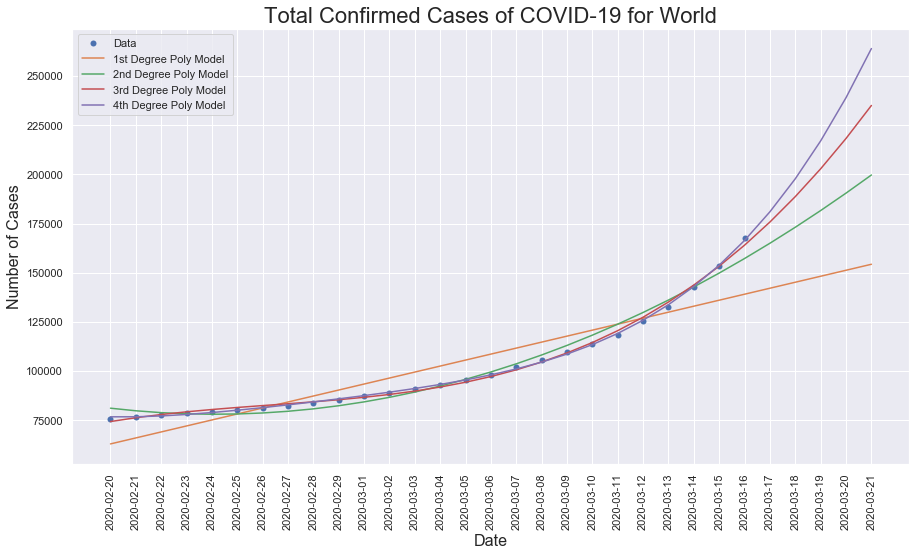

4th Degree Model R-Squared:  99.94 %


In [138]:
# Polynomial Regression
# ----------------------

# Create x from 0 to 25 to plot equation over the data
x = range(rows)

# Next, use Numpy polyfit(x, y, n) which returns the polynomial
# coefficients using the above least squares calculation and
# then use Numpy poly1d to create the polynomial equation as a
# function which can then be used for plotting
model_poly1 = np.poly1d(np.polyfit(x, y2, 1))
model_poly2 = np.poly1d(np.polyfit(x, y2, 2))
model_poly3 = np.poly1d(np.polyfit(x, y2, 3))
model_poly4 = np.poly1d(np.polyfit(x, y2, 4))

n = 5 # Number of days in the future to project
myline = range(rows + n)
RSqu = r2_score(y2, model_poly4(x))

# Add the next 5 days onto the x axis
future_dates = ['2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21']
x = list(x2)
x.extend(future_dates)

# Add blanks to data for next 4 days
y = np.append(y, np.zeros(n) + np.nan)

# Customise the size of the figure
plt.subplots(nrows=1, ncols=1,figsize=(15,8))

# Plot the data
plt.plot(x, y,
         marker='.', ms=12, markeredgecolor='none',
         linestyle='none', label='Data')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly1(myline), label='1st Degree Poly Model')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly2(myline), label='2nd Degree Poly Model')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly3(myline), label='3rd Degree Poly Model')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly4(myline), label='4th Degree Poly Model')

plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Cases', fontsize=16)
plt.legend(loc='upper left')
plt.title('Total Confirmed Cases of COVID-19 for World', fontsize=22)
plt.show()

print('4th Degree Model R-Squared: ', round(RSqu, 4) * 100, '%')

The **R-Squared value** represents the percentage of total variation described by the variation in x. It is just another value to help determine how the model fits the data.

### Future projections
---

Using updated data provided from the same source, we can measure how well our model projected future values. I will load in the new data set which measures upto 2020-03-20 and then plot the same models as before.

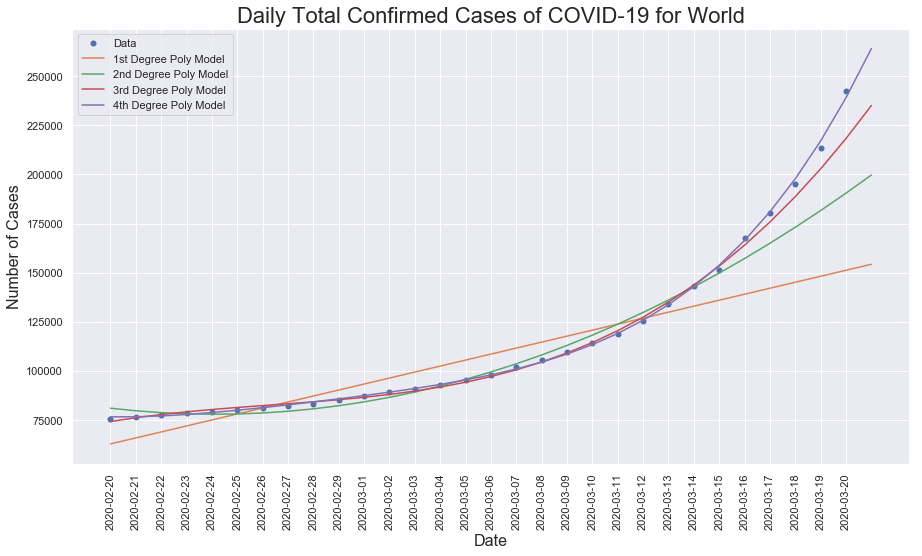

Actual day 59 value:  242476

4th degree model projected day 59 value:  239028

Relative error percentage:  1.42 %


In [139]:
data = pd.read_csv('full_data_20_march.csv')
data = data[data['location'] == 'World']
latest_figure = data.iloc[-1, 4] # Latest figure 2020-03-20
n = data[data['date'] == '2020-02-20'].index.values
data = data[data.index >= n[0]]
x = data['date']
y = data['total_cases']

# Customise the size of the figure
plt.subplots(nrows=1, ncols=1,figsize=(15,8))

# Plot the data
plt.plot(x, y,
         marker='.', ms=12, markeredgecolor='none',
         linestyle='none', label='Data')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly1(myline), label='1st Degree Poly Model')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly2(myline), label='2nd Degree Poly Model')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly3(myline), label='3rd Degree Poly Model')

# Plot 1st degree polynomial equation
plt.plot(myline, model_poly4(myline), label='4th Degree Poly Model')

plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Cases', fontsize=16)
plt.legend(loc='upper left')
plt.title('Daily Total Confirmed Cases of COVID-19 for World', fontsize=22)
plt.show()

print('Actual day 59 value: ', latest_figure)

projection = int(round(model_poly4(29), 0))

print('\n4th degree model projected day 59 value: ', projection)

print('\nRelative error percentage: ', round((abs(latest_figure - projection)/latest_figure)*100, 2), '%')

## The value of isolation
---

### Basic reproduction number
---

The basic reproduction number, otherwise known as $\mathrm{R}0$, tells us how many people, on average, each infected person will in turn infect. It is a **measure of how infectious** a disease is to help guide control strategies. If $\mathrm{R}0 < 1$, then the disease will die out. A typical seasonal flu strain has an $\mathrm{R}0$ of around 1.2 which means that **for every 5 infected** people, the disease will **spread to 6 new people** on average.

Currently, COVID-19 has an $\mathrm{R}0$ of around 2-3. To understand what this means can be illustrated by the following diagram:

![Reproduction Diagram](https://images.theconversation.com/files/312353/original/file-20200128-120039-bogv2t.png?ixlib=rb-1.1.0&q=45&auto=format&w=754&fit=clip)

### General model
---

Using this diagram, we can derive a mathematical expression for the total number of infected upto a specific step in the above diagram. For the general form we have:

$$\Large\begin{align*}
T &= \mathrm{R}0^0 + \mathrm{R}0^1 + \mathrm{R}0^2 + \cdots + \mathrm{R}0^n\\
&= \sum_{i=0}^n \mathrm{R}0^i
\end{align*}$$

Where $T$ is the total number of infected and $n$ is the number of steps down the diagram. For example, if we then input the values $\mathrm{R}0 = 2$ and $n = 3$ we have:

$$\Large T = 2^0 + 2^1 + 2^2 + 2^3 = 1 + 2 + 4 + 8 = 15$$

This is true and is exactly what is shown by the diargam. First there is **1** which passes it on to **2 more**, who then pass it on to **2 more each** (4), who then pass it on to **2 more each** (8). Leading to 15 total infected people.

For the worst case, COVID-19 has $\mathrm{R}0 = 3$ making the formual:

$$\Large T = \sum_{i=0}^n 3^i$$

We can use Python to explore how the magnitude of infected people increases with higher steps in the diagram.

In [140]:
# First, we create the steps and R0 variables
steps = 10
R0 = 3

# Next, we code the formula for T into Python
T = [R0**i for i in range(steps+1)]

# Place values into a data frame
reproduction = pd.DataFrame({
    'step': list(range(steps+1)),
    'T': T
})

display(reproduction)

# Finally, To find the value of T we sum all the values
T = sum(T)

print('Number of infected people after', steps, 'steps:', T)

,step,T
0,0,1
1,1,3
2,2,9
3,3,27
4,4,81
5,5,243
6,6,729
7,7,2187
8,8,6561
9,9,19683


Number of infected people after 10 steps: 88573


This is a simple way to understand why a contagious virus like COVID-19 **has spread so quickly** around the world. When left, it can spread as a power series of 3. Now we can see how isolation will change the spread.

### Isolation technique
---

Let's imagine that, on the first step, one of the 2 infected people made the decision to self-isolate by staying at home to recover. How does this change the overall spread? On the diagram this would look like:

![Reproduction Diagram with Isolation](Reproduction.png)

Mathematically, with $n = 3$ again, we have:

$$\Large T_\text{iso} = 1 + 1 + 2 + 4 = 8$$

That is **almost half** the amount of infected people **when isolation is used** when comapred to **15 with no isolation**. Now, if we apply what was done above for $n = 3$ but with $\mathrm{R}0 = 3$ instead, we have:

$$\Large\begin{align*}
T_\text{iso} &= 1 + 2 + 6 + 18\\
&= 1 + 2\cdot3^0 + 2\cdot3^1 + 2\cdot3^2\\
&= 1 + \sum_{i=1}^{3} 2\cdot3^{i-1} = 27
\end{align*}$$

This can be generalised for **placing one person from the first step into isolation** as the following:

$$\Large T_\text{iso} = 1 + \sum_{i=1}^{n} \Big(\mathrm{R}0-1\Big)\cdot\mathrm{R}0^{i-1}$$

To find the **percentage of lives saved** we first need to find the **difference** between the number of infected **without isolation** and the number of infected **with isolation** we subtract to give:

$$\Large\begin{align*}
T - T_\text{iso} &= \sum_{i=0}^{n} \mathrm{R}0^i - \left(1 + \sum_{i=1}^{n} \Big(\mathrm{R}0-1\Big)\cdot\mathrm{R}0^{i-1}\right)\\
&= 1 + \sum_{i=1}^{n} \mathrm{R}0^i - 1 - \sum_{i=1}^{n} \Big(\mathrm{R}0-1\Big)\cdot\mathrm{R}0^{i-1}\\
&= \sum_{i=1}^{n} \bigg(\mathrm{R}0^i - \Big(\mathrm{R}0-1\Big)\cdot\mathrm{R}0^{i-1}\bigg)\\
&= \sum_{i=1}^{n} \Big(\mathrm{R}0^i - \mathrm{R}0^i - \mathrm{R}0^{i-1}\Big)\\
&= \sum_{i=1}^{n} \mathrm{R}0^{i-1}
\end{align*}$$

Next, we find the **ratio** of number of lives saved to number of infected without isolation we divide the former by the latter to give:

$$\Large\begin{align*}
\dfrac{T - T_\text{iso}}{T} &= \dfrac{\sum_{i=1}^{n} \mathrm{R}0^{i-1}}{1 + \sum_{i=1}^{n} \mathrm{R}0^i}
\end{align*}$$

### Convergence
---

Does this equation **converge** to a value? If we take the limit of this result as $n\rightarrow\infty$ then we see that:

$$\Large
\lim_{n\rightarrow\infty} \dfrac{\sum_{i=1}^{n} \mathrm{R}0^{i-1}}{1 + \sum_{i=1}^{n} \mathrm{R}0^i} = \lim_{n\rightarrow\infty} \dfrac{\sum_{i=1}^{n} \mathrm{R}0^{i-1}}{\sum_{i=1}^{n} \mathrm{R}0^i}
$$

We can remove the 1 from the denominator since, for large $n$, its effect will be negligible. Thus:

$$\Large \lim_{n\rightarrow\infty} \sum_{i=1}^{n} \mathrm{R}0^{i-1-i} = \lim_{n\rightarrow\infty} \sum_{i=1}^{n} \mathrm{R}0^{-1} = \lim_{n\rightarrow\infty} \sum_{i=1}^{n} \dfrac{1}{\mathrm{R}0}$$

We have a limit that is **independent** of $n$. This means that the ratio will always converge to 1 over the reproduction value. Therefore, if 1 out of the 3 infected people self-isolate in the first step then the percentage of saved lives is:

$$\Large \dfrac{1}{\mathrm{R}0}\times100 = \dfrac{1}{3}\times100 = 33.33\%$$

Running all of the above in Python gives a numerical confirmation.

In [146]:
# Code the formula for T_iso into Python
T_iso = [1]
T_iso.extend([(R0 - 1) * R0**(i-1) for i in range(1, steps+1)])

# Place values into a data frame
reproduction_iso = pd.DataFrame({
    'step': list(range(steps+1)),
    'T_iso': T_iso
})

display(reproduction_iso)

# Finally, To find the value of T_iso we sum all the values
T_iso = sum(T_iso)

print('\nNumber of infected after', steps, 'steps with 1 isolation in step 1:', T_iso)

# Finally, calculate the difference and then the ratio to find percentage of saved lives
saved = T - T_iso
ratio = saved/T
print('\nNumber of people saved:', saved, 'or', round(ratio*100, 2), '%')

,step,T_iso
0,0,1
1,1,2
2,2,6
3,3,18
4,4,54
5,5,162
6,6,486
7,7,1458
8,8,4374
9,9,13122



Number of infected after 10 steps with 1 isolation in step 1: 59049

Number of people saved: 29524 or 33.33 %
